# BootCamp 2019 - Week 5

## Conditioning and Stability

Author: Martina Fraschini

In [1]:
# import packages
import numpy as np
from scipy import linalg as la
import sympy as sy
from matplotlib import pyplot as plt

### Problem 1

In [2]:
# define function
def conditioning(A):
    singvals = la.svdvals(A)
    if min(singvals) == 0:
        cond = np.inf
    else:
        cond = max(singvals) / min(singvals)
    return cond

A = np.array([[1, 2], [3, 4]])
print("Condition number for example matrix:")
print("My function: k(A) = ", conditioning(A))
print("Python:      k(A) = ", np.linalg.cond(A))

print("\nCondition number for orthonormal matrix:")
U = la.qr(A)
print("k(U) = ", conditioning(U[0]))

print("\nCondition number for singular matrix:")
S = np.array([[1, 1], [1, 1]])
print("k(S) = ", conditioning(S))

Condition number for example matrix:
My function: k(A) =  14.933034373659268
Python:      k(A) =  14.933034373659268

Condition number for orthonormal matrix:
k(U) =  1.0

Condition number for singular matrix:
k(S) =  inf


### Problem 2

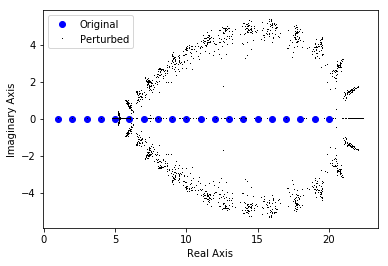

Average absolute condition numbers:  20.62133772338797
Average relative condition numbers:  1.423259958661678e+19


In [3]:
def perturbWilk(T):
    # roots of w
    w_roots = np.arange(1,21)
    # get the exact Wilkinson polynomial coefficients
    x, i = sy.symbols('x i')
    w = sy.poly_from_expr(sy.product(x-i, (i,1,20)))[0]
    w_coeffs = np.array(w.all_coeffs())
    plt.plot(w_roots.real, w_roots.imag, 'bo', label="Original")
    
    abscond = np.empty(T)
    relcond = np.empty(T)
    
    for t in range(T):
        # perturb coefficients
        r = np.random.normal(1,1e-10,len(w_coeffs))
        new_coeffs = w_coeffs * r
        new_roots = np.roots(np.poly1d(new_coeffs))
        if t == 0:
            plt.plot(new_roots.real, new_roots.imag, 'ko', marker=',', label="Perturbed")
        else:
            plt.plot(new_roots.real, new_roots.imag, 'ko', marker=',')
        
        abscond[t] = la.norm(new_roots - w_roots, np.inf) / la.norm(r, np.inf)
        relcond[t] = abscond[t] * la.norm(w_coeffs, np.inf) / la.norm(w_roots, np.inf)
        
    plt.xlabel("Real Axis")
    plt.ylabel("Imaginary Axis")
    plt.legend()
    plt.show()
    
    return abscond.mean(), relcond.mean()

acond, rcond = perturbWilk(100)
print("Average absolute condition numbers: ", acond)
print("Average relative condition numbers: ", rcond)

### Problem 3

In [4]:
def eigencond(A):
    reals = np.random.normal(0, 1e-10, A.shape)
    imags = np.random.normal(0, 1e-10, A.shape)
    H = reals + 1j*imags
    
    Aeigs = la.eigvals(A)
    AHeigs = la.eigvals(A+H)
    
    abscond = la.norm(Aeigs - AHeigs, 2) / la.norm(H, 2)
    relcond = abscond * la.norm(A, 2) / la.norm(Aeigs, 2)
    
    return abscond, relcond

A = np.array([[1,2],[3,4]])
Aabscond, Arelcond = eigencond(A)
print("Absolute condition number: ", Aabscond)
print("Relative condition number: ", Arelcond)

Absolute condition number:  1.031770376258721
Relative condition number:  1.0470636569600122


### Problem 4

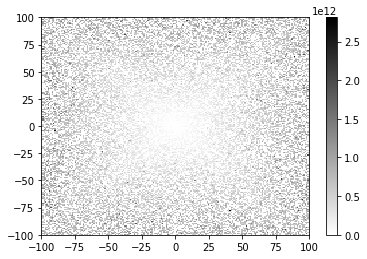

In [5]:
# define function
def gridcond(bounds, res):
    x_grid = np.linspace(bounds[0],bounds[1], res)
    y_grid = np.linspace(bounds[2],bounds[3], res)
    rcond = np.empty([res,res])
    for i in range(res):
        for j in range(res):
            M = np.array([[1,x_grid[i]],[y_grid[j],1]])
            _, rcond[i,j] = eigencond(M)
    X, Y = np.meshgrid(x_grid, y_grid)
    fig, ax = plt.subplots(1)
    cax = ax.pcolormesh(X, Y, rcond, cmap='gray_r')
    fig.colorbar(cax)
    plt.show()

x_min = -100
x_max = 100
y_min = -100
y_max = 100
npoints = 200
gridcond([x_min,x_max,y_min,y_max],npoints)

### Problem 5

In [6]:
def myOLS(n):
    # load stability data
    xk, yk = np.load("stability_data.npy").T
    A = np.vander(xk, n+1)
    
    # inverse method
    p1 = la.inv(A.T@A) @ A.T @ yk
    
    # QR method
    Q, R = la.qr(A, mode='economic')
    p2 = la.solve_triangular(R, Q.T@yk)

    # fitting
    fit1 = np.polyval(p1, xk)
    fit2 = np.polyval(p2, xk)
    
    # plot
    plt.plot(xk, yk, 'ko', marker="*", markersize=2)
    plt.plot(xk, fit1, label="Normal Equations")
    plt.plot(xk, fit2, label="QR solver")
    plt.title("Polynomial approximation of degree {}".format(n))
    plt.legend()
    plt.show()
    
    err1 = la.norm(fit1 - yk, 2)
    err2 = la.norm(fit2 - yk, 2)
    
    return err1, err2

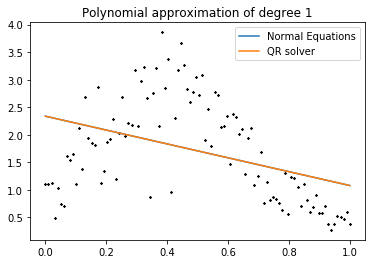

Forward error of normal equations:  8.360236870426958
Forward error of QR solver:  8.360236870426958


In [7]:
e1, e2 = myOLS(1)
print("Forward error of normal equations: ", e1)
print("Forward error of QR solver: ", e2)

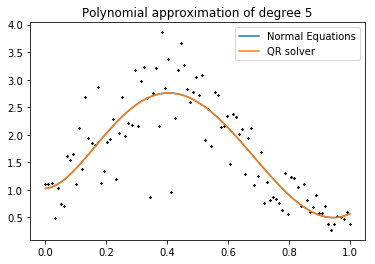

Forward error of normal equations:  4.854970503107443
Forward error of QR solver:  4.854970503107444


In [8]:
e1, e2 = myOLS(5)
print("Forward error of normal equations: ", e1)
print("Forward error of QR solver: ", e2)

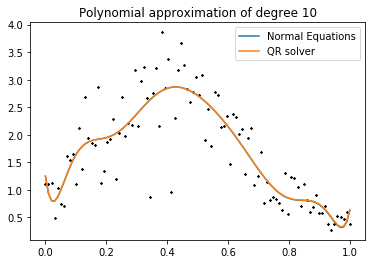

Forward error of normal equations:  4.6444890740031655
Forward error of QR solver:  4.644309587539317


In [9]:
e1, e2 = myOLS(10)
print("Forward error of normal equations: ", e1)
print("Forward error of QR solver: ", e2)

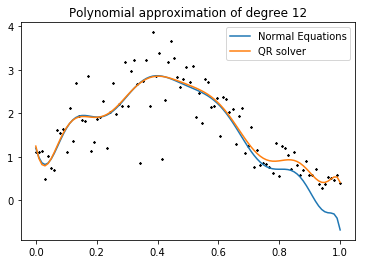

Forward error of normal equations:  5.283258916756381
Forward error of QR solver:  4.5934080267857205


In [10]:
e1, e2 = myOLS(12)
print("Forward error of normal equations: ", e1)
print("Forward error of QR solver: ", e2)

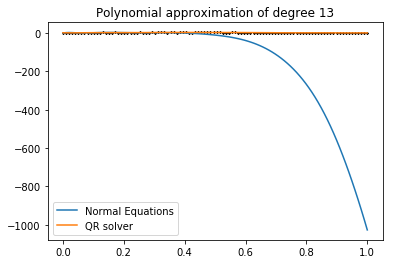

Forward error of normal equations:  2972.649536695347
Forward error of QR solver:  4.59338952408192


In [11]:
e1, e2 = myOLS(13)
print("Forward error of normal equations: ", e1)
print("Forward error of QR solver: ", e2)

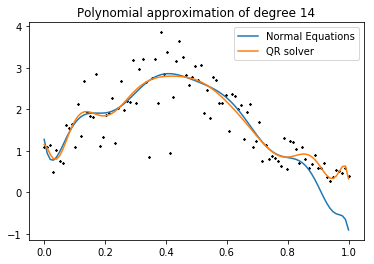

Forward error of normal equations:  5.564833717171037
Forward error of QR solver:  4.568370944874799


In [12]:
e1, e2 = myOLS(14)
print("Forward error of normal equations: ", e1)
print("Forward error of QR solver: ", e2)

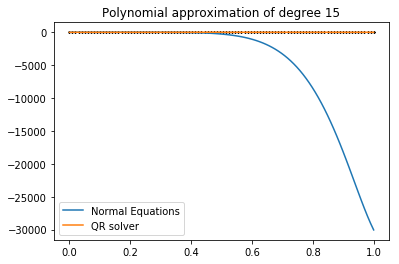

Forward error of normal equations:  92499.01651111136
Forward error of QR solver:  4.527556140564378


In [13]:
e1, e2 = myOLS(15)
print("Forward error of normal equations: ", e1)
print("Forward error of QR solver: ", e2)

### Problem 6

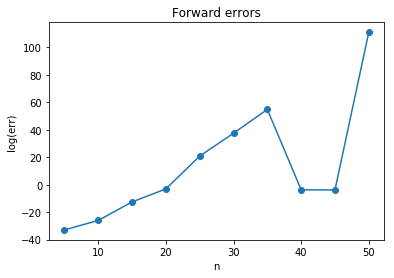

In [14]:
nvec = np.array([i*5 for i in range(1,11)])
x = sy.symbols('x')
err = np.empty(len(nvec))
for ind, n in enumerate(nvec):
    # true value of the integral
    true_integ = float(sy.integrate(x**n * sy.exp(x-1), (x,0,1)))
    
    # approximation of the integral
    subfact = float(sy.subfactorial(n))
    fact = float(sy.factorial(n))
    appr_integ = (-1)**n * subfact + (-1)**(n+1) * fact / float(sy.exp(1))
    
    err[ind] = abs(true_integ - appr_integ)
    
plt.plot(nvec, np.log(err), 'o-')
plt.xlabel("n")
plt.ylabel("log(err)")
plt.title("Forward errors")
plt.show()

Stability depends on the value for $n$. If $n$ is too high then the algorithm doesn't work.